# DQN

## Dependencies

In [1]:
from pathlib import Path
import os

import ipdb

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import pandas as pd
import seaborn as sns
from imojify import imojify

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
from utils import Params, random_choice
from environment_tensor import WrappedEnvironment, Actions, CONTEXTS_LABELS, Cues

In [4]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

In [5]:
sns.set_theme(font_scale=1.5)
mpl.rcParams["font.family"] = ["sans-serif"]
mpl.rcParams["font.sans-serif"] = [
    "Fira Sans",
    "Computer Modern Sans Serif",
    "DejaVu Sans",
    "Verdana",
    "Arial",
    "Helvetica",
]
# plt.style.use("ggplot")

In [6]:
ROOT_PATH = Path("env").parent
PLOTS_PATH = ROOT_PATH / "plots"
print(f"Plots path: `{PLOTS_PATH.absolute()}`")

Plots path: `/home/kir0ul/Projects/RL_Olfaction/TriangleTask/plots`


In [7]:
def check_plots():
    if not PLOTS_PATH.exists():
        os.mkdir(PLOTS_PATH)

## Parameters

In [8]:
p = Params(
    seed=42,
    n_runs=1,
    total_episodes=1000,
    epsilon=0.2,
    alpha=0.05,
    gamma=0.9,
    nHiddenUnits=5 * 5 + 2,
)
p

Params(seed=42, rng=None, n_runs=1, total_episodes=1000, epsilon=0.2, gamma=0.9, alpha=0.05, nLayers=5, nHiddenUnits=27, n_observations=None, n_actions=None)

In [9]:
# # Set the seed
# p.rng = np.random.default_rng(p.seed)

## The environment

In [10]:
# Load the environment
env = WrappedEnvironment()

In [11]:
# Get number of actions
# n_actions = env.action_space.n
p.n_actions = env.numActions

# Get the number of state observations
# state, info = env.reset()
state = env.reset()
p.n_observations = len(state)

print(f"Number of actions: {p.n_actions}")
print(f"Number of observations: {p.n_observations}")

Number of actions: 4
Number of observations: 2


## Running the environment

In [12]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_units=16):
        super(DQN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(n_observations, n_units),
            nn.Linear(n_units, n_units),
            nn.Linear(n_units, n_units),
            # nn.ReLU(),
            nn.Linear(n_units, n_actions),
        )

    def forward(self, x):
        return self.mlp(x)

In [13]:
net = DQN(
    n_observations=p.n_observations, n_actions=p.n_actions, n_units=p.nHiddenUnits
).to(device)
net

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=27, bias=True)
    (1): Linear(in_features=27, out_features=27, bias=True)
    (2): Linear(in_features=27, out_features=27, bias=True)
    (3): Linear(in_features=27, out_features=4, bias=True)
  )
)

In [14]:
# print("Model parameters:")
# print(list(net.parameters()))
print("\n\nParameters sizes summary:")
print([item.shape for item in net.parameters()])



Parameters sizes summary:
[torch.Size([27, 2]), torch.Size([27]), torch.Size([27, 27]), torch.Size([27]), torch.Size([27, 27]), torch.Size([27]), torch.Size([4, 27]), torch.Size([4])]


In [15]:
summary(net, input_size=[state.shape], verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [4]                       --
├─Sequential: 1-1                        [4]                       --
│    └─Linear: 2-1                       [27]                      81
│    └─Linear: 2-2                       [27]                      756
│    └─Linear: 2-3                       [27]                      756
│    └─Linear: 2-4                       [4]                       112
Total params: 1,705
Trainable params: 1,705
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [16]:
optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.05
    maximize: False
    weight_decay: 0.01
)

In [17]:
class EpsilonGreedy:
    def __init__(
        self,
        epsilon,
        rng=None,
    ):
        self.epsilon = epsilon
        # if rng:
        #     self.rng = rng

    def choose_action(self, action_space, state, state_action_values):
        """Choose an action a in the current world state (s)"""

        def sample(action_space):
            return random_choice(action_space)

        # # First we randomize a number
        # if hasattr(self, "rng"):
        #     explor_exploit_tradeoff = self.rng.uniform(0, 1)
        # else:
        #     explor_exploit_tradeoff = np.random.uniform(0, 1)
        explor_exploit_tradeoff = torch.rand(1)

        # Exploration
        if explor_exploit_tradeoff.item() < self.epsilon:
            # action = action_space.sample()
            action = sample(action_space)

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `argmax()` would always take the first one)
            if torch.all(state_action_values == state_action_values[0]):
                action = sample(action_space)
            else:
                action = torch.argmax(state_action_values)
        return action

In [18]:
explorer = EpsilonGreedy(epsilon=p.epsilon, rng=p.rng)

### Main loop

In [19]:
rewards = torch.zeros((p.total_episodes, p.n_runs), device=device)
steps = torch.zeros((p.total_episodes, p.n_runs), device=device)
episodes = torch.arange(p.total_episodes, device=device)
all_states = []
all_actions = []
losses = [[] for _ in range(p.n_runs)]
episode_durations = []

for run in range(p.n_runs):  # Run several times to account for stochasticity
    # Reset model
    net = DQN(
        n_observations=p.n_observations, n_actions=p.n_actions, n_units=p.nHiddenUnits
    ).to(device)
    optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{p.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        state = state.clone().float().detach().to(device)
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            state_action_values = net(state).to(device)  # Q(s_t)
            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                state_action_values=state_action_values,
            )

            # Record states and actions
            all_states.append(state)
            all_actions.append(Actions(action.item()).name)

            next_state, reward, done = env.step(
                action=action.item(), current_state=state
            )

            # # Compute V(s_{t+1}) for all next states.
            # # Expected values of actions are computed based
            # # on the "older" network, then selecting their best reward.
            # # Should be either the expected state value or 0 in case the state is final.
            # next_state_values = torch.zeros_like(state_action_values, device=device)

            # Update only the weights related to action taken
            # next_state_values = state_action_values
            # if done:
            #     # next_state_values[action.item()] = 0
            #     next_state_values = torch.zeros(1, device=device)
            #     expected_state_action_values = reward
            # else:
            #     # next_state_values[action.item()] = net(state).max()

            # See DQN paper for equations: https://arxiv.org/abs/1312.5602
            state_action_value = state_action_values[action].unsqueeze(-1)  # Q(s_t, a)
            if done:
                expected_state_action_values = reward
            else:
                with torch.no_grad():
                    next_state_values = (
                        net(next_state).to(device).max().unsqueeze(-1)
                    )  # Q(s_t+1, a)
                expected_state_action_value = (
                    reward + p.gamma * next_state_values
                )  # y_j (Bellman optimality equation)

            # Compute loss
            criterion = nn.MSELoss()
            loss = criterion(
                input=state_action_value, target=expected_state_action_value
            )  # TD update

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()

            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(net.parameters(), 100)
            optimizer.step()

            # Move to the next state
            state = next_state

            total_rewards += reward
            step_count += 1
            losses[run].append(loss.item())

        episode_durations.append(step_count + 1)
        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count

In [20]:
# weights_metrics

In [21]:
# grads_metrics

In [22]:
# grads_metrics["avg_rolling"] = np.nan
# grads_metrics["std_rolling"] = np.nan
# for id in grads_metrics.id.unique():
#     grads_metrics.loc[grads_metrics[grads_metrics["id"] == id].index, "avg_rolling"] = (
#         grads_metrics.loc[grads_metrics[grads_metrics["id"] == id].index, "avg"]
#         .rolling(20)
#         .mean()
#     )
#     grads_metrics.loc[grads_metrics[grads_metrics["id"] == id].index, "std_rolling"] = (
#         grads_metrics.loc[grads_metrics[grads_metrics["id"] == id].index, "std"]
#         .rolling(20)
#         .mean()
#     )
# grads_metrics

## Visualization

In [23]:
# def plot_weights(weights_metrics):
#     """Plot the weights."""
#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

#     sns.lineplot(x="steps_global", y="avg", hue="id", data=weights_metrics, ax=ax[0])
#     ax[0].set(ylabel="Weights (avg)")
#     ax[0].set(xlabel="Steps")

#     sns.lineplot(x="steps_global", y="std", hue="id", data=weights_metrics, ax=ax[1])
#     ax[1].set(ylabel="Weights (std)")
#     ax[1].set(xlabel="Steps")

#     fig.tight_layout()
#     plt.show()

In [24]:
# plot_weights(weights_metrics)

In [25]:
# def plot_gradients(grads_metrics):
#     """Plot the gradienta."""
#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

#     sns.lineplot(
#         x="steps_global",
#         y="avg_rolling",
#         hue="id",
#         data=grads_metrics,
#         ax=ax[0],
#         palette=sns.color_palette()[0 : len(grads_metrics.id.unique())],
#     )
#     ax[0].set(ylabel="Gradients (avg)")
#     ax[0].set(xlabel="Steps")

#     sns.lineplot(
#         x="steps_global",
#         y="std_rolling",
#         hue="id",
#         data=grads_metrics,
#         ax=ax[1],
#         palette=sns.color_palette()[0 : len(grads_metrics.id.unique())],
#     )
#     ax[1].set(ylabel="Gradients (std)")
#     ax[1].set(xlabel="Steps")

#     fig.tight_layout()
#     plt.show()

In [26]:
# plot_gradients(grads_metrics)

In [27]:
def postprocess(episodes, p, rewards, steps):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": episodes.tile(p.n_runs).cpu(),
            "Rewards": rewards.T.flatten().cpu(),
            "Steps": steps.T.flatten().cpu(),
        }
    )
    # res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    return res

In [28]:
res = postprocess(episodes, p, rewards, steps)
res

,Episodes,Rewards,Steps
0,0,10.0,23.0
1,1,0.0,47.0
2,2,10.0,1.0
3,3,0.0,1.0
4,4,0.0,13.0
...,...,...,...
995,995,10.0,14.0
996,996,10.0,65.0
997,997,10.0,28.0
998,998,10.0,2.0


As a sanity check, we will plot the distributions of states and actions
with the following function:

In [29]:
def plot_states_actions_distribution(states, actions):
    """Plot the distributions of states and actions."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    # sns.histplot(data=states, ax=ax[0])
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(
        [item.value for item in Actions], labels=[item.name for item in Actions]
    )
    ax[1].set_title("Actions")
    fig.tight_layout()
    plt.show()

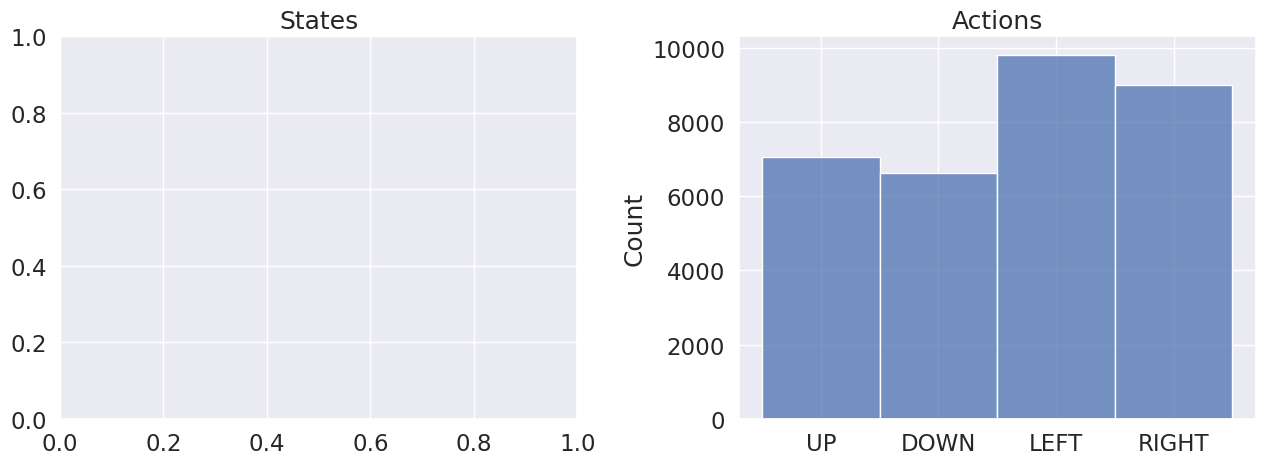

In [30]:
plot_states_actions_distribution(all_states, all_actions)

In [31]:
def plot_steps_and_rewards(df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(data=df, x="Episodes", y="Rewards", ax=ax[0])
    ax[0].set(
        ylabel=f"Rewards\naveraged over {p.n_runs} runs" if p.n_runs > 1 else "Rewards"
    )

    sns.lineplot(data=df, x="Episodes", y="Steps", ax=ax[1])
    ax[1].set(
        ylabel=f"Steps number\naveraged over {p.n_runs} runs"
        if p.n_runs > 1
        else "Steps number"
    )

    fig.tight_layout()
    plt.show()

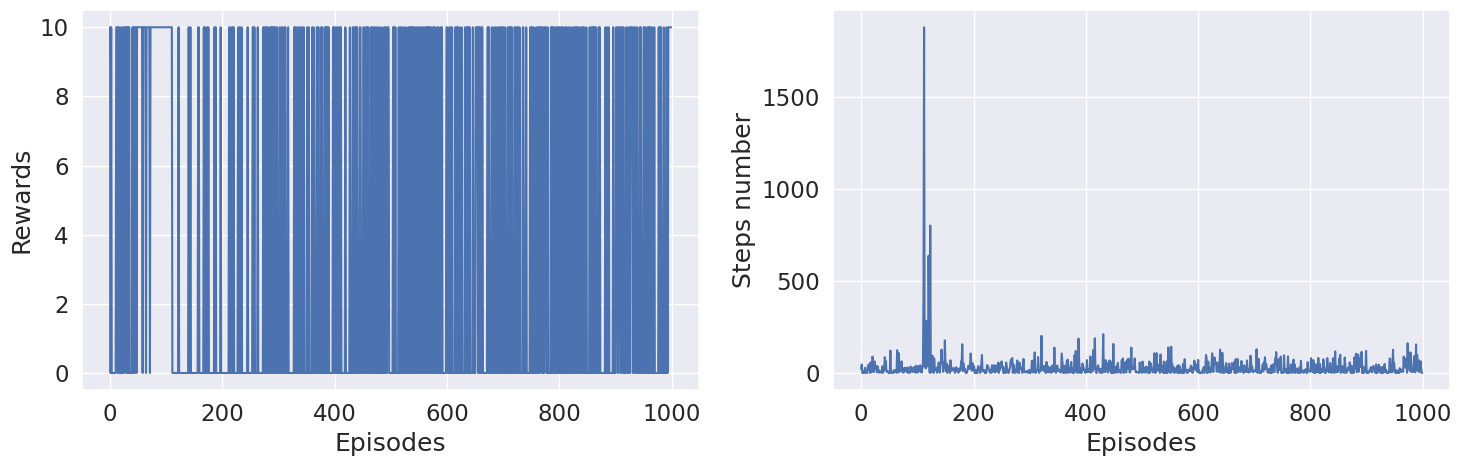

In [32]:
plot_steps_and_rewards(res)

In [33]:
window_size = 10
for idx, loss in enumerate(losses):
    current_loss = torch.tensor(loss, device=device)
    losses_rolling_avg = nn.functional.avg_pool1d(
        current_loss.view(1, 1, -1), kernel_size=window_size
    ).squeeze()
    tmp_df = pd.DataFrame(
        data={
            "Run": idx * torch.ones(len(losses_rolling_avg), device=device).int().cpu(),
            "Steps": torch.arange(0, len(losses_rolling_avg), device=device).cpu(),
            "Loss": losses_rolling_avg.cpu(),
        }
    )
    if idx == 0:
        loss_df = tmp_df
    else:
        loss_df = pd.concat((loss_df, tmp_df))
loss_df

,Run,Steps,Loss
0,0,0,3.078851e+01
1,0,1,4.995547e+00
2,0,2,1.427781e+03
3,0,3,2.709752e+02
4,0,4,4.140943e+00
...,...,...,...
3243,0,3243,1.301235e-18
3244,0,3244,1.283982e-18
3245,0,3245,1.269992e-18
3246,0,3246,1.253802e-18


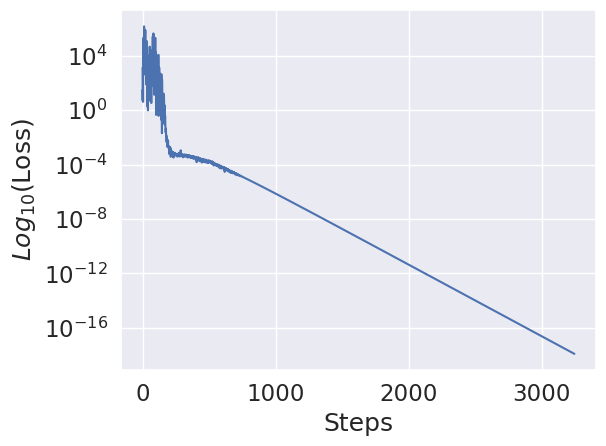

In [34]:
fig, ax = plt.subplots()
sns.lineplot(data=loss_df, x="Steps", y="Loss", ax=ax)
ax.set(
    ylabel=f"$Log_{{10}}(\\text{{Loss}})$\naveraged over {p.n_runs} runs"
    if p.n_runs > 1
    else "$Log_{10}(\\text{Loss})$"
)
ax.set(xlabel="Steps")
ax.set(yscale="log")
fig.tight_layout()
plt.show()

In [35]:
loss_df.iloc[-1].Loss

1.2337247875766617e-18

In [51]:
with torch.no_grad():
    q_values = torch.nan * torch.empty(
        (len(env.tiles_locations), len(Cues), p.n_actions), device=device
    )
    for tile_i, tile_v in enumerate(env.tiles_locations):
        for cue_i, cue_v in enumerate(Cues):
            # if state_i in [0, len(q_values) - 1]:
            #     # q_values[state_i,] = 0
            #     continue
            state = torch.tensor([tile_v, cue_v.value], device=device).float()
            q_values[tile_i, cue_i, :] = net(state).to(device)
q_values

tensor([[[1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08],
         [1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08],
         [1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08]],

        [[1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08],
         [1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08],
         [1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08]],

        [[1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08],
         [1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08],
         [1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08]],

        [[1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08],
         [1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08],
         [1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08]],

        [[1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08],
         [1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08],
         [1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08]],

        [[1.1096e-08, 1.1097e-08, 1.1095e-08, 1.1095e-08],
         [1.1096e-08, 1.1097e-08, 1.1095e-08, 

In [ ]:
env.tiles_locations.reshape((env.rows, env.cols))

In [ ]:
[item for item in Actions]

In [ ]:
[item for item in Cues]

In [ ]:
net(torch.tensor([4, 1]).float())

In [ ]:
net(torch.tensor([19, 1]).float()).argmax()